# Forecasting_Assignment_CocaCola_Prices

In [1]:
##importing the required libraries for Analysis

import pandas as pd
import numpy as np
from numpy import sqrt

from pandas import Grouper
from pandas import DataFrame

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_squared_error
from pandas.plotting import lag_plot
from statsmodels.graphics.tsaplots import plot_acf

from statsmodels.tsa.seasonal import seasonal_decompose
## with the help of this we will be able to creat graphs for the dfferent components of time series data 
#like trends, level, sesional components and residual data

from statsmodels.tsa.holtwinters import SimpleExpSmoothing # SES
from statsmodels.tsa.holtwinters import Holt # Holts Exponential Smoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [2]:
# Import Dataset
df = pd.read_excel('CocaCola_Sales_Rawdata.xlsx')
print('Shape of the data',df.shape)
df.head(10)

Shape of the data (42, 2)


,Quarter,Sales
0,Q1_86,1734.827000
1,Q2_86,2244.960999
2,Q3_86,2533.804993
3,Q4_86,2154.962997
4,Q1_87,1547.818996
5,Q2_87,2104.411995
6,Q3_87,2014.362999
7,Q4_87,1991.746998
8,Q1_88,1869.049999
9,Q2_88,2313.631996


## Data Exploration

In [3]:
df.isnull().any()

Quarter    False
Sales      False
dtype: bool

In [4]:
df.isnull().sum()

Quarter    0
Sales      0
dtype: int64

In [5]:
df.shape

(42, 2)

In [6]:
#Checking the data types
df.dtypes

Quarter     object
Sales      float64
dtype: object

In [7]:
#Unique values for every feature
df.nunique()

Quarter    42
Sales      42
dtype: int64

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42 entries, 0 to 41
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Quarter  42 non-null     object 
 1   Sales    42 non-null     float64
dtypes: float64(1), object(1)
memory usage: 800.0+ bytes


In [9]:
df[df.duplicated()].shape

(0, 2)

In [10]:
df[df.duplicated()]

,Quarter,Sales


In [11]:
df.describe()

,Sales
count,42.000000
mean,2994.353308
std,977.930896
min,1547.818996
25%,2159.714247
50%,2782.376999
75%,3609.250000
max,5253.000000


### Feature Engineering

#### Converting the Quarters into Years

In [13]:
df['Quarter_Year'] = df['Quarter'].str.split('_').apply(lambda x: ' 19'.join(x[:]))
#Clean way to convert quarterly periods to datetime in pandas
df.head(10)

,Quarter,Sales,Quarter_Year
0,Q1_86,1734.827000,Q1 1986
1,Q2_86,2244.960999,Q2 1986
2,Q3_86,2533.804993,Q3 1986
3,Q4_86,2154.962997,Q4 1986
4,Q1_87,1547.818996,Q1 1987
5,Q2_87,2104.411995,Q2 1987
6,Q3_87,2014.362999,Q3 1987
7,Q4_87,1991.746998,Q4 1987
8,Q1_88,1869.049999,Q1 1988
9,Q2_88,2313.631996,Q2 1988


### Coverting Quarter Years with Quarter Start Date Year (Date Month and Year)

In [15]:
# converting into datetime formate as the index was not in correct formate.
df['Date'] = (
    pd.to_datetime(
        df['Quarter_Year'].str.split(' ').apply(lambda x: ''.join(x[::-1]))
,dayfirst=True))
df.head(10)

,Quarter,Sales,Quarter_Year,Date
0,Q1_86,1734.827000,Q1 1986,1986-01-01
1,Q2_86,2244.960999,Q2 1986,1986-04-01
2,Q3_86,2533.804993,Q3 1986,1986-07-01
3,Q4_86,2154.962997,Q4 1986,1986-10-01
4,Q1_87,1547.818996,Q1 1987,1987-01-01
5,Q2_87,2104.411995,Q2 1987,1987-04-01
6,Q3_87,2014.362999,Q3 1987,1987-07-01
7,Q4_87,1991.746998,Q4 1987,1987-10-01
8,Q1_88,1869.049999,Q1 1988,1988-01-01
9,Q2_88,2313.631996,Q2 1988,1988-04-01


## Extracting the Quarters and putting in column

In [17]:
#Droping the Column Quarter and Quarter_Year from the data set as we had get our required ate time column 
# and no need for object coumn
df.drop(columns=['Quarter','Quarter_Year'],axis=1,inplace=True)


In [18]:
df1 = df[['Date','Sales']]
## here we are shifting the columns of date and Sales to make it correct for date column as we need to make the date column a

In [19]:
df1.set_index('Date',inplace=True)
df1.index.year

Int64Index([1986, 1986, 1986, 1986, 1987, 1987, 1987, 1987, 1988, 1988, 1988,
            1988, 1989, 1989, 1989, 1989, 1990, 1990, 1990, 1990, 1991, 1991,
            1991, 1991, 1992, 1992, 1992, 1992, 1993, 1993, 1993, 1993, 1994,
            1994, 1994, 1994, 1995, 1995, 1995, 1995, 1996, 1996],
           dtype='int64', name='Date')

In [20]:
df1.head()

,Sales
Date,
1986-01-01,1734.827000
1986-04-01,2244.960999
1986-07-01,2533.804993
1986-10-01,2154.962997
1987-01-01,1547.818996


### Separating Month and Year into Separate Column for Visualization and removing meaningful insight of the data

In [21]:
df["Date"] = pd.to_datetime(df.Date,format="%b-%y")
df["month"] = df.Date.dt.strftime("%b") # month extraction
df["year"] = df.Date.dt.strftime("%Y") # year extraction
df.head(10)

,Sales,Date,month,year
0,1734.827000,1986-01-01,Jan,1986
1,2244.960999,1986-04-01,Apr,1986
2,2533.804993,1986-07-01,Jul,1986
3,2154.962997,1986-10-01,Oct,1986
4,1547.818996,1987-01-01,Jan,1987
5,2104.411995,1987-04-01,Apr,1987
6,2014.362999,1987-07-01,Jul,1987
7,1991.746998,1987-10-01,Oct,1987
8,1869.049999,1988-01-01,Jan,1988
9,2313.631996,1988-04-01,Apr,1988


## Data Visualization

In [23]:
## Visualization of Data Checking the line plot,Histogram and Density Plots,create a density plot,
## Box and Whisker Plots by Interval,Lag Plot, Autocorrelation Plot

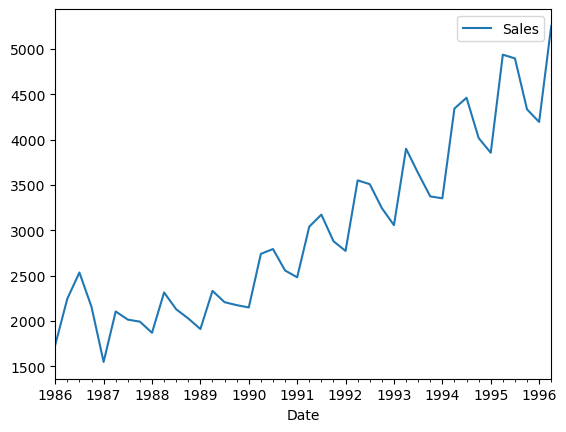

In [24]:
# Line plot
df1.plot()
plt.show()

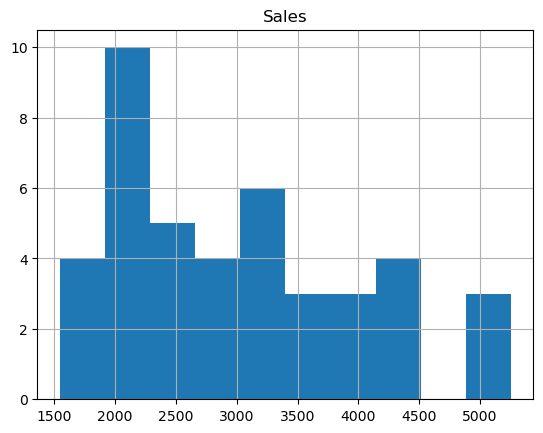

In [25]:
##Histogram and Density Plots

df1.hist()
plt.show()

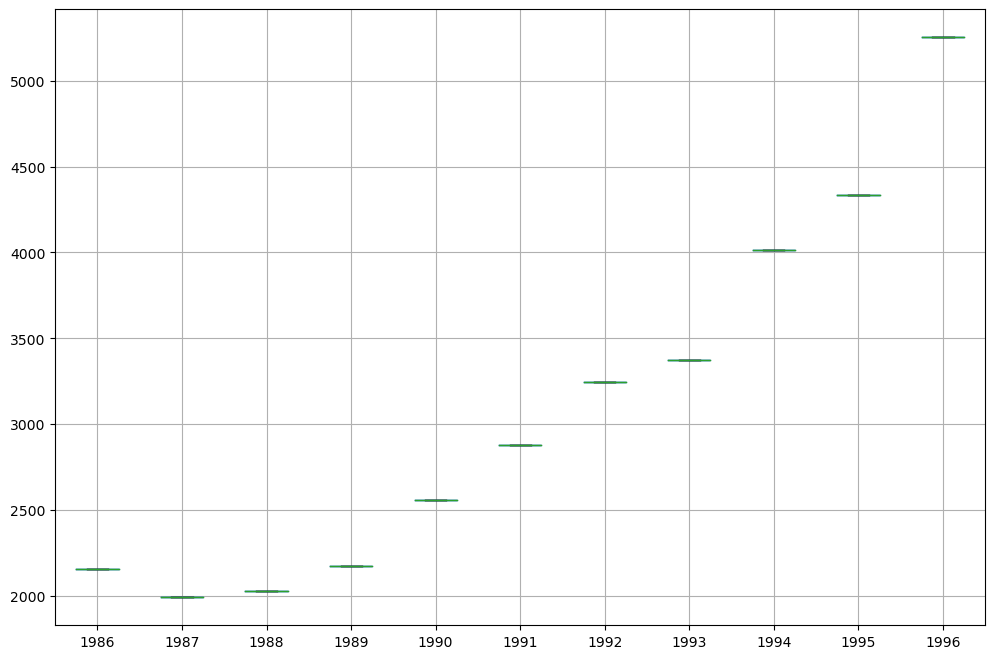

In [26]:
#Box and Whisker Plots by Interval
groups = df1.groupby(Grouper(freq='q'))
plt.figure(figsize=(12,8))
years = DataFrame()
for name, group in groups:
    years[name.year] = group.values.reshape(-1,)
years.boxplot()
plt.show()

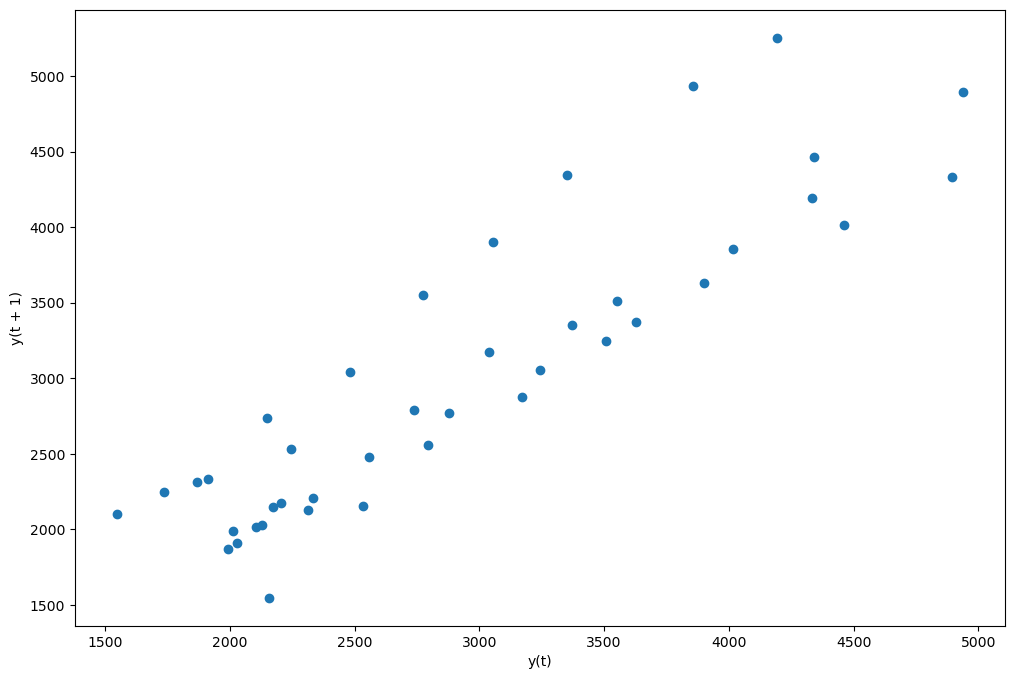

In [27]:
##Lag_plot
plt.figure(figsize=(12,8))
lag_plot(df1)
plt.show()

<Figure size 1200x800 with 0 Axes>

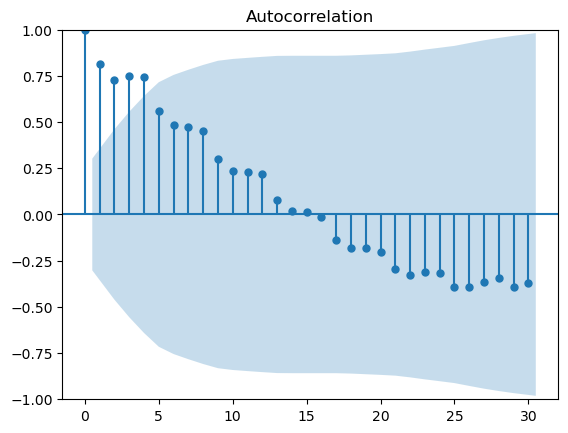

In [28]:
#Autocorrelation Plot

plt.figure(figsize=(12,8))
plot_acf(df1,lags=30)
plt.show()

## UpSampling

In [31]:
upsampled = df1.resample('M').mean()
print(upsampled.head(32))

                  Sales
Date                   
1986-01-31  1734.827000
1986-02-28          NaN
1986-03-31          NaN
1986-04-30  2244.960999
1986-05-31          NaN
1986-06-30          NaN
1986-07-31  2533.804993
1986-08-31          NaN
1986-09-30          NaN
1986-10-31  2154.962997
1986-11-30          NaN
1986-12-31          NaN
1987-01-31  1547.818996
1987-02-28          NaN
1987-03-31          NaN
1987-04-30  2104.411995
1987-05-31          NaN
1987-06-30          NaN
1987-07-31  2014.362999
1987-08-31          NaN
1987-09-30          NaN
1987-10-31  1991.746998
1987-11-30          NaN
1987-12-31          NaN
1988-01-31  1869.049999
1988-02-29          NaN
1988-03-31          NaN
1988-04-30  2313.631996
1988-05-31          NaN
1988-06-30          NaN
1988-07-31  2128.320000
1988-08-31          NaN


                  Sales
Date                   
1986-01-31  1734.827000
1986-02-28  1904.871666
1986-03-31  2074.916332
1986-04-30  2244.960999
1986-05-31  2341.242330
1986-06-30  2437.523661
1986-07-31  2533.804993
1986-08-31  2407.524328
1986-09-30  2281.243663
1986-10-31  2154.962997
1986-11-30  1952.581664
1986-12-31  1750.200330
1987-01-31  1547.818996
1987-02-28  1733.349996
1987-03-31  1918.880995


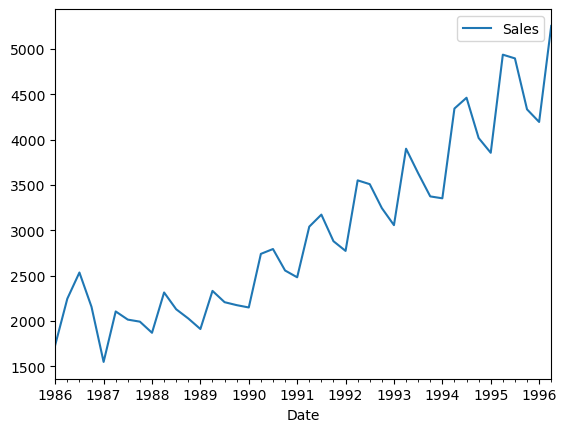

In [32]:
interpolated = upsampled.interpolate(method='linear') ## interplation was done for nan values which we get after doing upsampling by month
print(interpolated.head(15))
interpolated.plot()
plt.show()

## Tranformations

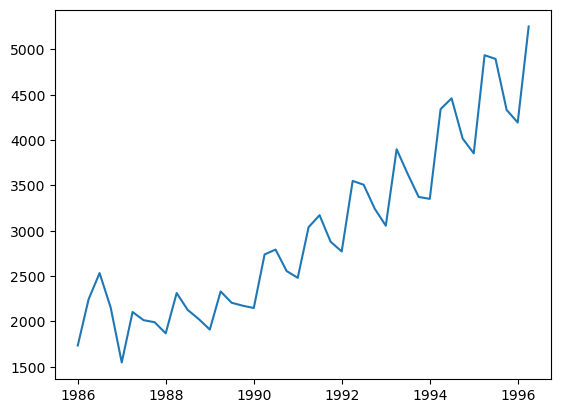

In [33]:
# line plot
plt.plot(df1)

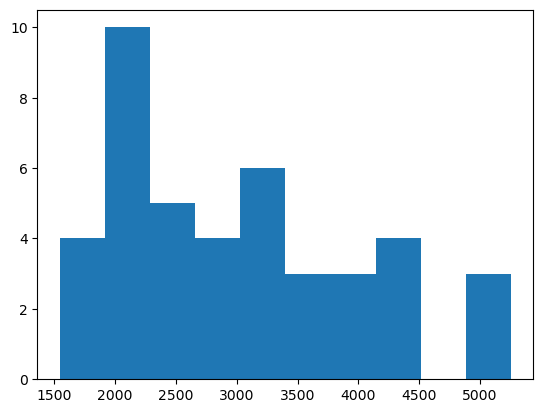

In [34]:
# histogram
plt.hist(df1)
plt.show()

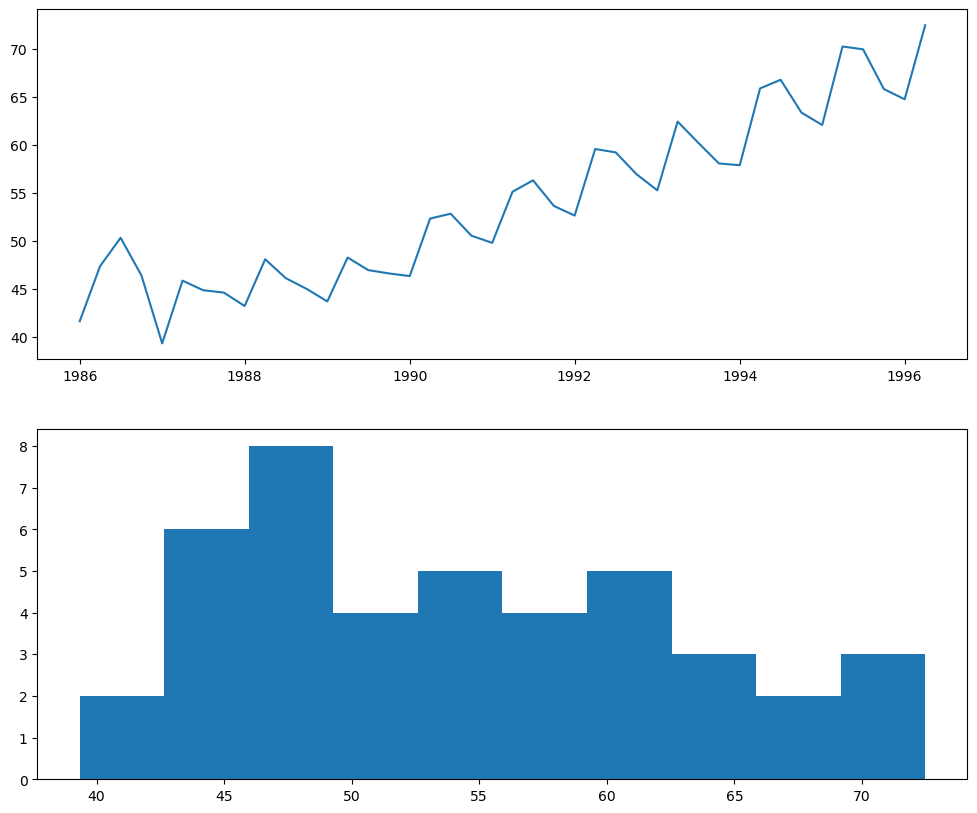

In [35]:
#Square Root Transform
square_root= pd.DataFrame()
square_root = df1[['Sales']]
square_root['Sales'] = np.sqrt(square_root.Sales)

# line chart
fig=plt.figure(figsize=(12,10))
plt.subplot(211)
plt.plot(square_root['Sales'])
#Histogram
plt.subplot(212)
plt.hist(square_root['Sales'])
plt.show()

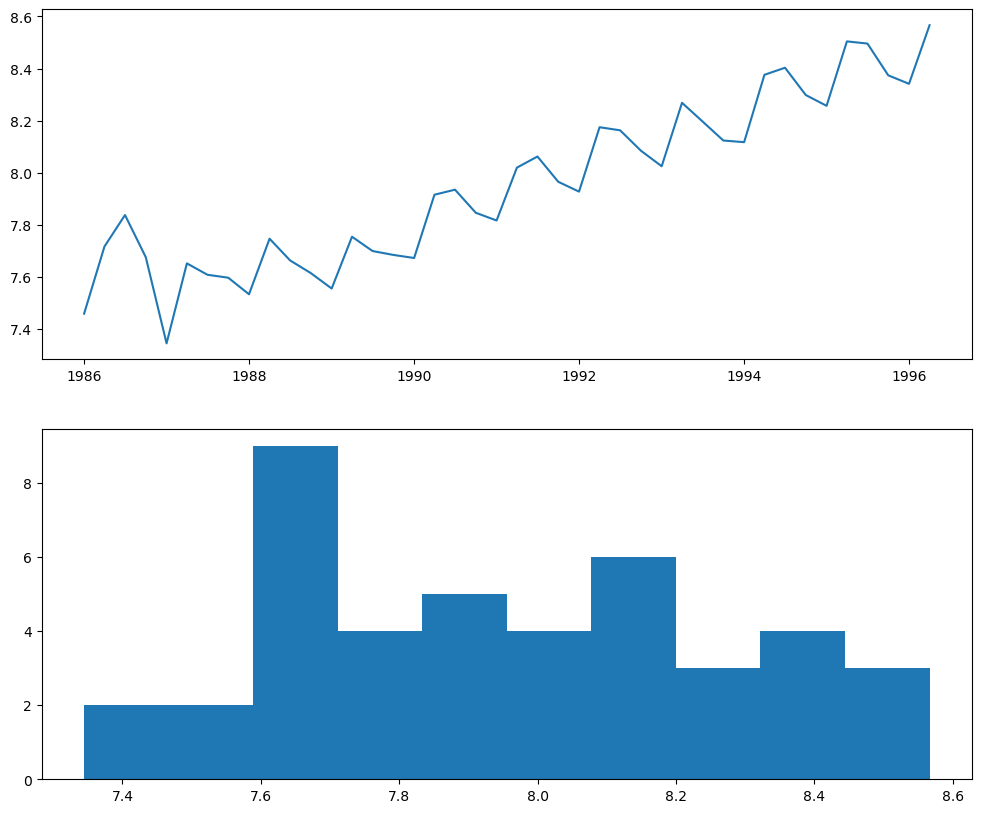

In [36]:
# Log Transform
log = pd.DataFrame()
log = df1[['Sales']]
log['Sales'] = np.log(log.Sales)

# line chart
fig=plt.figure(figsize=(12,10))
plt.subplot(211)
plt.plot(log['Sales'])
#Histogram
plt.subplot(212)
plt.hist(log['Sales'])
plt.show()


In [37]:
Train = interpolated.head(112)
Test = interpolated.tail(12)

### Moving Average

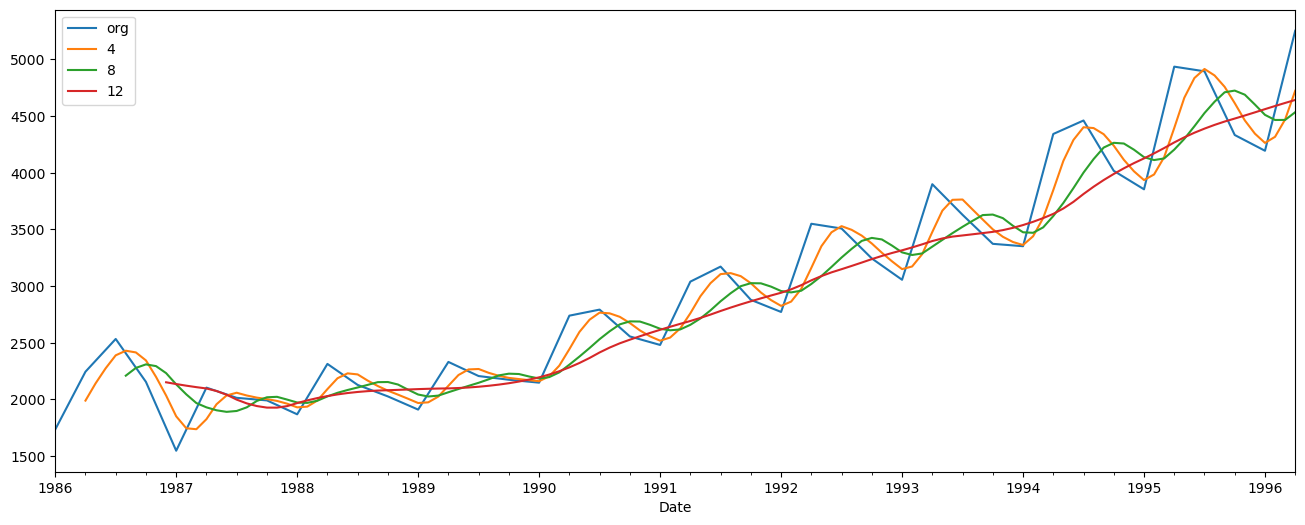

In [38]:
plt.figure(figsize=(16,6))
interpolated.Sales.plot(label="org")
for i in range(4,13,4):
    interpolated["Sales"].rolling(i).mean().plot(label=str(i))
plt.legend(loc='best')

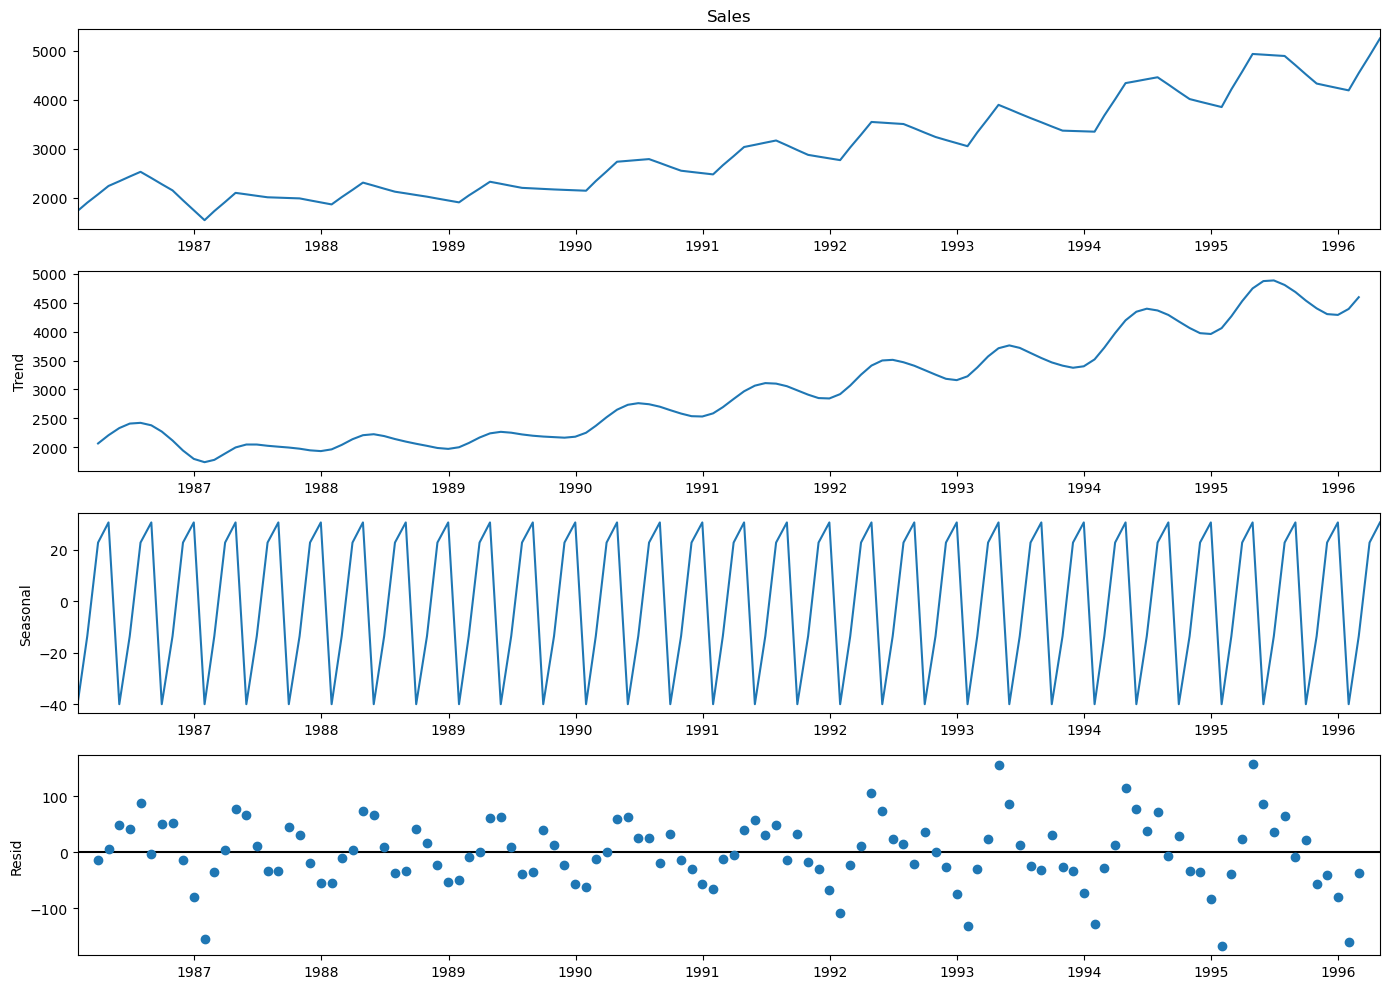

In [39]:
# Time series decomposition plot 
decompose_ts_add = seasonal_decompose(interpolated.Sales,period=4)
with plt.rc_context():
    plt.rc("figure", figsize=(14,10))
    decompose_ts_add.plot()
    plt.show()

## ACF plots and PACF plots

### Autocorrelation Function (ACF)

C:\Users\ADMIN\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


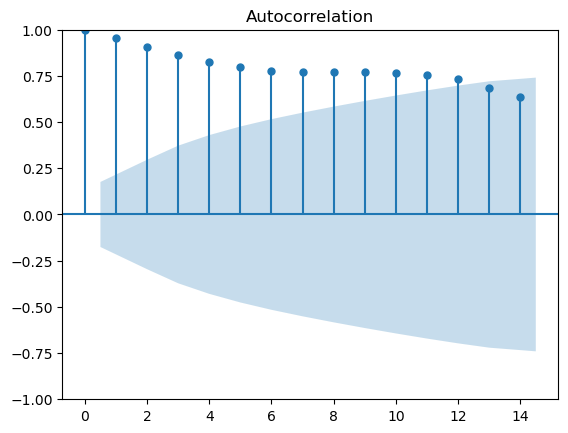

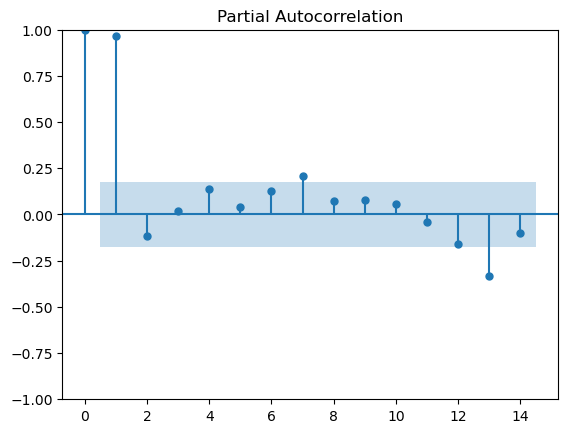

In [40]:
import statsmodels.graphics.tsaplots as tsa_plots

tsa_plots.plot_acf(interpolated.Sales,lags=14)
tsa_plots.plot_pacf(interpolated.Sales,lags=14)
plt.show()

## Evaluation Metric MAPE

In [41]:
def MAPE(pred,org):
    temp = np.abs((pred-org)/org)*100
    return np.mean(temp)

### Simple Exponential Method

In [42]:
ses_model = SimpleExpSmoothing(Train["Sales"]).fit(smoothing_level=0.2)
pred_ses = ses_model.predict(start = Test.index[0],end = Test.index[-1])
MAPE(pred_ses,Test.Sales)

7.528920151221706

## Holt method

In [44]:
# Holt method 
hw_model = Holt(Train["Sales"]).fit(smoothing_level=0.1, smoothing_slope=0.2)
pred_hw = hw_model.predict(start = Test.index[0],end = Test.index[-1])
MAPE(pred_hw,Test.Sales)

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_8840\3240688955.py:2: FutureWarning: the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead.
  hw_model = Holt(Train["Sales"]).fit(smoothing_level=0.1, smoothing_slope=0.2)


7.9715438298078

## Holts winter exponential smoothing with additive seasonality and additive trend

In [45]:
hwe_model_add_add = ExponentialSmoothing(Train["Sales"],
                                         seasonal="add",trend="add",seasonal_periods=12).fit(smoothing_level=0.1, smoothing_slope=0.2) #add the trend to the model
pred_hwe_add_add = hwe_model_add_add.predict(start = Test.index[0],end = Test.index[-1])
MAPE(pred_hwe_add_add,Test.Sales)

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_8840\2752987487.py:1: FutureWarning: the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead.
  hwe_model_add_add = ExponentialSmoothing(Train["Sales"],


4.963328784192284

## Holts winter exponential smoothing with multiplicative seasonality and additive trend

In [46]:
hwe_model_mul_add = ExponentialSmoothing(Train["Sales"],seasonal="mul",trend="add",
                                         seasonal_periods=12).fit(smoothing_level=0.1, smoothing_slope=0.2) 
pred_hwe_mul_add = hwe_model_mul_add.predict(start = Test.index[0],end = Test.index[-1])
MAPE(pred_hwe_mul_add,Test.Sales)

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_8840\916528878.py:1: FutureWarning: the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead.
  hwe_model_mul_add = ExponentialSmoothing(Train["Sales"],seasonal="mul",trend="add",


4.78490230286808

In [47]:
rmse_hwe_mul_add = sqrt(mean_squared_error(pred_hwe_mul_add,Test.Sales))
rmse_hwe_mul_add

249.10229299271208

### Final Model by combining train and test

In [48]:
hwe_model_add_add = ExponentialSmoothing(interpolated["Sales"],seasonal="add",trend="add",seasonal_periods=10).fit()

#Forecasting for next 10 time periods
hwe_model_add_add.forecast(10)

1996-05-31    5634.022667
1996-06-30    6028.465140
1996-07-31    6403.865614
1996-08-31    6767.772230
1996-09-30    7059.368652
1996-10-31    7370.796050
1996-11-30    7617.021925
1996-12-31    7954.348607
1997-01-31    8248.783688
1997-02-28    8612.157059
Freq: M, dtype: float64

In [49]:
interpolated.reset_index(inplace=True)
interpolated

,Date,Sales
0,1986-01-31,1734.827000
1,1986-02-28,1904.871666
2,1986-03-31,2074.916332
3,1986-04-30,2244.960999
4,1986-05-31,2341.242330
...,...,...
119,1995-12-31,4240.333333
120,1996-01-31,4194.000000
121,1996-02-29,4547.000000
122,1996-03-31,4900.000000


In [50]:
for i,row in interpolated.iterrows():
  interpolated['t']=np.arange(1,len(interpolated)+1)
interpolated

,Date,Sales,t
0,1986-01-31,1734.827000,1
1,1986-02-28,1904.871666,2
2,1986-03-31,2074.916332,3
3,1986-04-30,2244.960999,4
4,1986-05-31,2341.242330,5
...,...,...,...
119,1995-12-31,4240.333333,120
120,1996-01-31,4194.000000,121
121,1996-02-29,4547.000000,122
122,1996-03-31,4900.000000,123


In [51]:
interpolated['t_sq'] = (interpolated['t'])**2
## inserted t_sq column with values
interpolated

,Date,Sales,t,t_sq
0,1986-01-31,1734.827000,1,1
1,1986-02-28,1904.871666,2,4
2,1986-03-31,2074.916332,3,9
3,1986-04-30,2244.960999,4,16
4,1986-05-31,2341.242330,5,25
...,...,...,...,...
119,1995-12-31,4240.333333,120,14400
120,1996-01-31,4194.000000,121,14641
121,1996-02-29,4547.000000,122,14884
122,1996-03-31,4900.000000,123,15129


In [52]:
interpolated["month"] = interpolated.Date.dt.strftime("%b") # month extraction
interpolated["year"] = interpolated.Date.dt.strftime("%Y") # year extraction
interpolated

,Date,Sales,t,t_sq,month,year
0,1986-01-31,1734.827000,1,1,Jan,1986
1,1986-02-28,1904.871666,2,4,Feb,1986
2,1986-03-31,2074.916332,3,9,Mar,1986
3,1986-04-30,2244.960999,4,16,Apr,1986
4,1986-05-31,2341.242330,5,25,May,1986
...,...,...,...,...,...,...
119,1995-12-31,4240.333333,120,14400,Dec,1995
120,1996-01-31,4194.000000,121,14641,Jan,1996
121,1996-02-29,4547.000000,122,14884,Feb,1996
122,1996-03-31,4900.000000,123,15129,Mar,1996


In [53]:
months = pd.get_dummies(interpolated['month']) ## converting the dummy variables for month column
months

,Apr,Aug,Dec,Feb,Jan,Jul,Jun,Mar,May,Nov,Oct,Sep
0,0,0,0,0,1,0,0,0,0,0,0,0
1,0,0,0,1,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,1,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
119,0,0,1,0,0,0,0,0,0,0,0,0
120,0,0,0,0,1,0,0,0,0,0,0,0
121,0,0,0,1,0,0,0,0,0,0,0,0
122,0,0,0,0,0,0,0,1,0,0,0,0


In [54]:
months = months[['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']]
## storing the months as serial wise again in months variable

In [55]:
Coka_Cola = pd.concat([interpolated,months],axis=1)
Coka_Cola.head()

,Date,Sales,t,t_sq,month,year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
0,1986-01-31,1734.827000,1,1,Jan,1986,1,0,0,0,0,0,0,0,0,0,0,0
1,1986-02-28,1904.871666,2,4,Feb,1986,0,1,0,0,0,0,0,0,0,0,0,0
2,1986-03-31,2074.916332,3,9,Mar,1986,0,0,1,0,0,0,0,0,0,0,0,0
3,1986-04-30,2244.960999,4,16,Apr,1986,0,0,0,1,0,0,0,0,0,0,0,0
4,1986-05-31,2341.242330,5,25,May,1986,0,0,0,0,1,0,0,0,0,0,0,0


In [56]:
Coka_Cola['log_sales'] = np.log(Coka_Cola['Sales'])
Coka_Cola

,Date,Sales,t,t_sq,month,year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,log_sales
0,1986-01-31,1734.827000,1,1,Jan,1986,1,0,0,0,0,0,0,0,0,0,0,0,7.458663
1,1986-02-28,1904.871666,2,4,Feb,1986,0,1,0,0,0,0,0,0,0,0,0,0,7.552170
2,1986-03-31,2074.916332,3,9,Mar,1986,0,0,1,0,0,0,0,0,0,0,0,0,7.637676
3,1986-04-30,2244.960999,4,16,Apr,1986,0,0,0,1,0,0,0,0,0,0,0,0,7.716443
4,1986-05-31,2341.242330,5,25,May,1986,0,0,0,0,1,0,0,0,0,0,0,0,7.758437
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119,1995-12-31,4240.333333,120,14400,Dec,1995,0,0,0,0,0,0,0,0,0,0,0,1,8.352397
120,1996-01-31,4194.000000,121,14641,Jan,1996,1,0,0,0,0,0,0,0,0,0,0,0,8.341410
121,1996-02-29,4547.000000,122,14884,Feb,1996,0,1,0,0,0,0,0,0,0,0,0,0,8.422223
122,1996-03-31,4900.000000,123,15129,Mar,1996,0,0,1,0,0,0,0,0,0,0,0,0,8.496990


<Axes: xlabel='month', ylabel='year'>

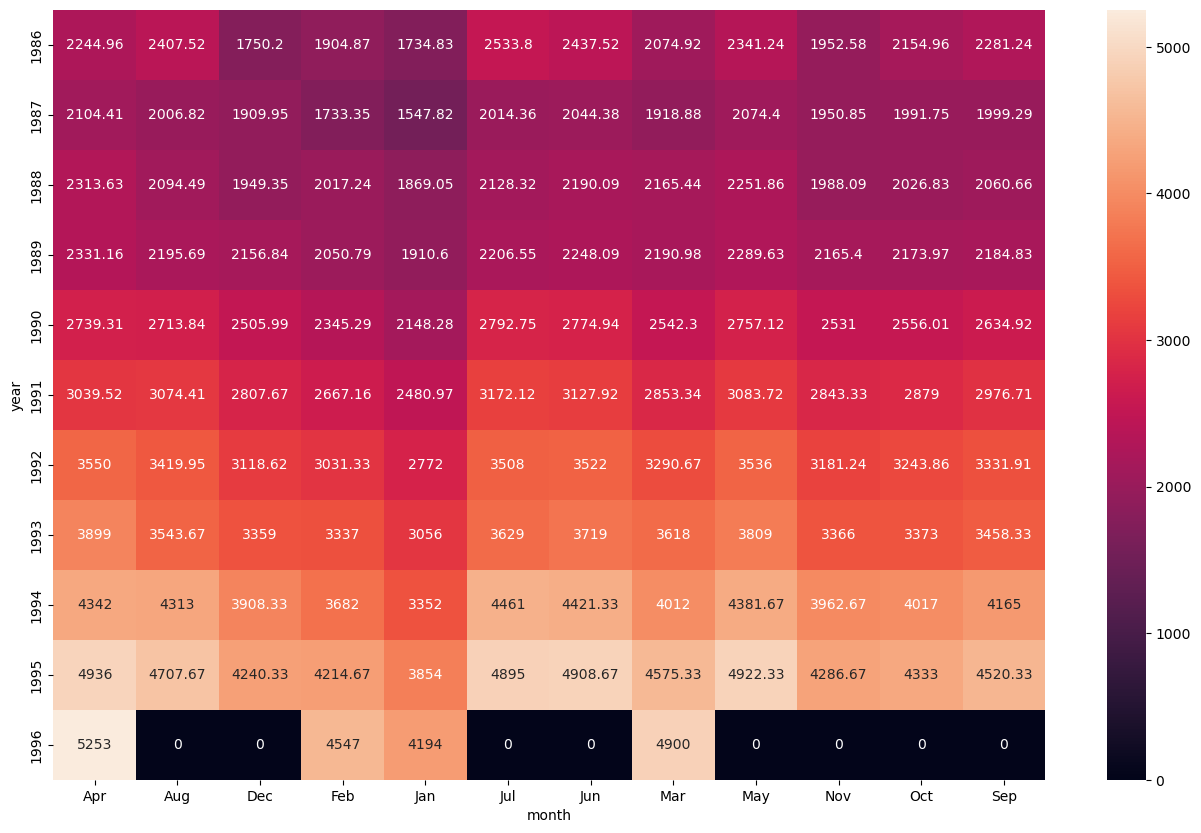

In [57]:
plt.figure(figsize=(16,10))
heatmap_y_month = pd.pivot_table(data=Coka_Cola,values="Sales",index="year",columns="month",aggfunc="mean",fill_value=0)
sns.heatmap(heatmap_y_month,annot=True,fmt="g")

<Axes: xlabel='year', ylabel='Sales'>

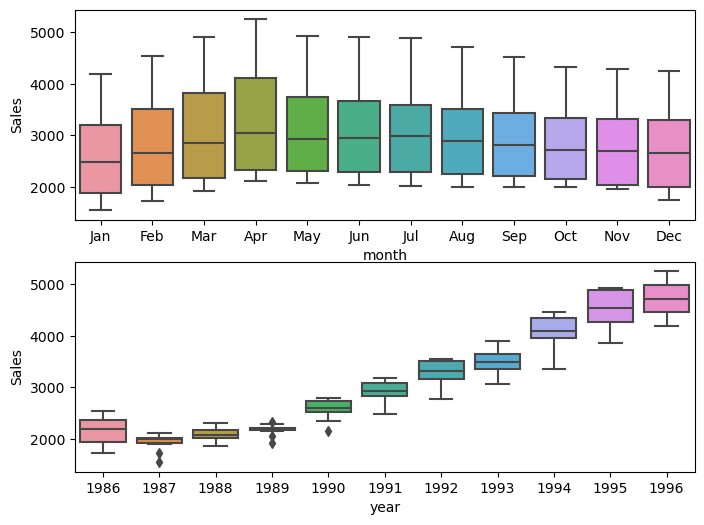

In [58]:
# Boxplot 
plt.figure(figsize=(8,6))
plt.subplot(211)
sns.boxplot(x="month",y="Sales",data= Coka_Cola)
plt.subplot(212)
sns.boxplot(x="year",y="Sales",data=Coka_Cola)

<Axes: xlabel='year', ylabel='Sales'>

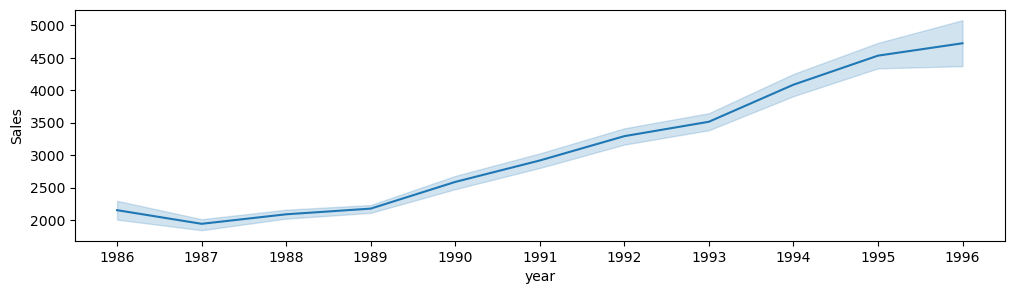

In [59]:
plt.figure(figsize=(12,3))
sns.lineplot(x="year",y="Sales",data=Coka_Cola)

## Splitting data

In [60]:
Train = Coka_Cola.head(110) # training data
Test = Coka_Cola.tail(14) # test Data

In [61]:
#Linear Model
import statsmodels.formula.api as smf 

linear_model = smf.ols('Sales~t',data=Train).fit()
pred_linear =  pd.Series(linear_model.predict(pd.DataFrame(Test['t'])))
rmse_linear = np.sqrt(np.mean((np.array(Test['Sales'])-np.array(pred_linear))**2))
rmse_linear

638.120822592281

In [62]:
#Exponential
Exp = smf.ols('log_sales~t',data=Train).fit()
pred_Exp = pd.Series(Exp.predict(pd.DataFrame(Test['t'])))
rmse_Exp = np.sqrt(np.mean((np.array(Test['Sales'])-np.array(np.exp(pred_Exp)))**2))
rmse_Exp

494.44069305460084

In [63]:
#Quadratic 

Quad = smf.ols('Sales~t+t_sq',data=Train).fit()
pred_Quad = pd.Series(Quad.predict(Test[["t","t_sq"]]))
rmse_Quad = np.sqrt(np.mean((np.array(Test['Sales'])-np.array(pred_Quad))**2))
rmse_Quad

387.2816008292835

In [64]:
#Additive seasonality 

add_sea = smf.ols('Sales~Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov',data=Train).fit()
pred_add_sea = pd.Series(add_sea.predict(Test[['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov']]))
rmse_add_sea = np.sqrt(np.mean((np.array(Test['Sales'])-np.array(pred_add_sea))**2))
rmse_add_sea

1881.8135899060217

In [65]:
#Additive Seasonality Quadratic 

add_sea_Quad = smf.ols('Sales~t+t_sq+Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov',data=Train).fit()
pred_add_sea_quad = pd.Series(add_sea_Quad.predict(Test[['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','t','t_sq']]))
rmse_add_sea_quad = np.sqrt(np.mean((np.array(Test['Sales'])-np.array(pred_add_sea_quad))**2))
rmse_add_sea_quad

242.77660443468852

In [66]:
##Multiplicative Seasonality

Mul_sea = smf.ols('log_sales~Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov',data = Train).fit()
pred_Mult_sea = pd.Series(Mul_sea.predict(Test))
rmse_Mult_sea = np.sqrt(np.mean((np.array(Test['Sales'])-np.array(np.exp(pred_Mult_sea)))**2))
rmse_Mult_sea

1973.2620608123104

In [67]:
#Multiplicative Additive Seasonality 

Mul_Add_sea = smf.ols('log_sales~t+Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov',data = Train).fit()
pred_Mult_add_sea = pd.Series(Mul_Add_sea.predict(Test))
rmse_Mult_add_sea = np.sqrt(np.mean((np.array(Test['Sales'])-np.array(np.exp(pred_Mult_add_sea)))**2))
rmse_Mult_add_sea

275.2750321115779

In [68]:
#Compareing the results 

data = {"MODEL":pd.Series(["rmse_linear","rmse_Exp","rmse_Quad","rmse_add_sea","rmse_add_sea_quad","rmse_Mult_sea","rmse_Mult_add_sea"]),"RMSE_Values":pd.Series([rmse_linear,rmse_Exp,rmse_Quad,rmse_add_sea,rmse_add_sea_quad,rmse_Mult_sea,rmse_Mult_add_sea])}
table_rmse=pd.DataFrame(data)
table_rmse.sort_values(['RMSE_Values'])

,MODEL,RMSE_Values
4,rmse_add_sea_quad,242.776604
6,rmse_Mult_add_sea,275.275032
2,rmse_Quad,387.281601
1,rmse_Exp,494.440693
0,rmse_linear,638.120823
3,rmse_add_sea,1881.813590
5,rmse_Mult_sea,1973.262061
